In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.image as img
%matplotlib inline
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import matplotlib
import wget

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6602234355586937578
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1395847783
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14543328437980133753
physical_device_desc: "device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [24]:
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [25]:
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [4]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [5]:
food_list = ['apple_pie','pizza','omelette', 'samosa']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [6]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into samosa


In [7]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into samosa


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    'train_mini',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 3000 images belonging to 4 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    'test_mini',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1000 images belonging to 4 classes.


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

In [12]:
base_model.trainable = False

In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=test_generator)

Epoch 1/15
94/94 [==============================] - 127s 1s/step - loss: 0.4860 - accuracy: 0.8130 - val_loss: 0.3762 - val_accuracy: 0.8550
Epoch 2/15
94/94 [==============================] - 110s 1s/step - loss: 0.4332 - accuracy: 0.8377 - val_loss: 0.3532 - val_accuracy: 0.8690
Epoch 3/15
94/94 [==============================] - 111s 1s/step - loss: 0.4094 - accuracy: 0.8487 - val_loss: 0.3492 - val_accuracy: 0.8700
Epoch 4/15
94/94 [==============================] - 98s 1s/step - loss: 0.3840 - accuracy: 0.8570 - val_loss: 0.4159 - val_accuracy: 0.8380
Epoch 5/15
94/94 [==============================] - 127s 1s/step - loss: 0.3465 - accuracy: 0.8740 - val_loss: 0.3603 - val_accuracy: 0.8630
Epoch 6/15
94/94 [==============================] - 145s 2s/step - loss: 0.3503 - accuracy: 0.8673 - val_loss: 0.3197 - val_accuracy: 0.8780
Epoch 7/15
94/94 [==============================] - 106s 1s/step - loss: 0.3064 - accuracy: 0.8863 - val_loss: 0.3285 - val_accuracy: 0.8780
Epoch 8/15
94/

In [17]:
model.save_weights("model.h5")
model.save('model.h5')
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

C:\Users\abhij\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


32/32 - 21s - loss: 0.3276 - accuracy: 0.8750
Test accuracy: 0.875


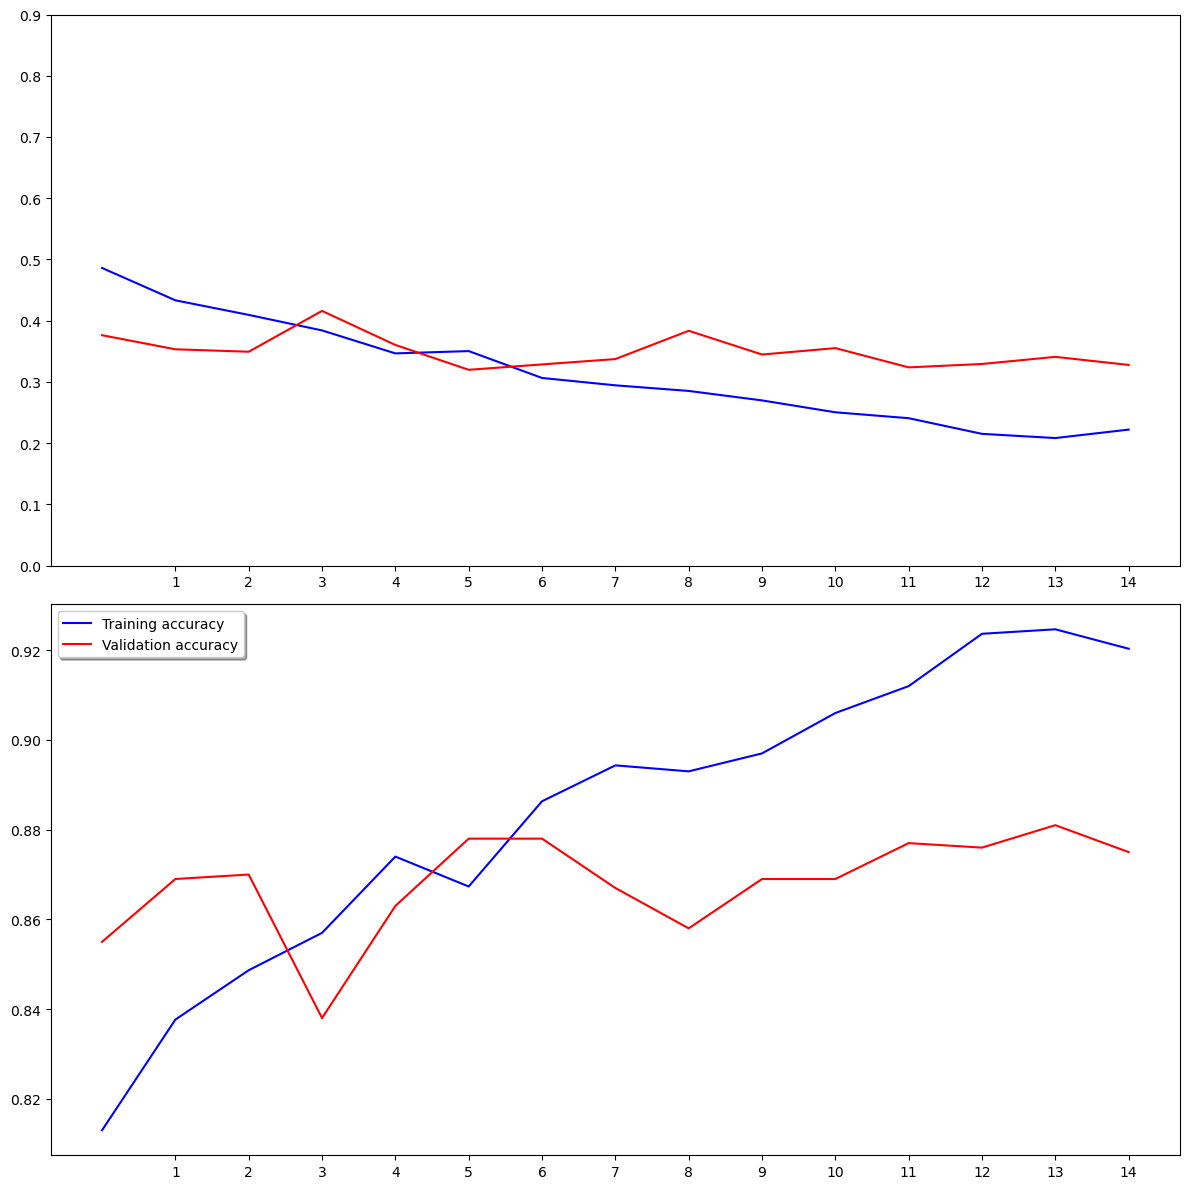

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:

def predict_class(model, images):
      food_list = ['apple_pie','pizza','omelette', 'samosa']
      pred_values = []
      for img in images:
        img = image.load_img(img, target_size=(224, 224))
        img = image.img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255.                                      

        pred = model.predict(img)
        index = np.argmax(pred)
        food_list.sort()
        pred_value = food_list[index]
        pred_values.append(pred_value)
      return pred_values

In [28]:
wget.download("http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg", "samosa.jpg")
wget.download("https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg", "applepie.jpg")
wget.download("https://en.wikipedia.org/wiki/File:Masala_omelette.JPG", "omelette.jpg")
food_list = ['apple_pie','pizza','omelette']

images = []
images.append('pizza.jpg')
images.append('applepie.jpg')
images.append('samosa.jpg')
images.append('omelette.jpg')
predict_class(model, images)

100% [..............................................................................] 75058 / 75058

['pizza', 'apple_pie', 'samosa', 'pizza']